# Starwars Network Analysis

In [7]:
# Standard library imports
import json
from typing import Tuple
import copy
import random

# Related third party imports
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Import any other libraries you used to create the figure, e.g., plotly
import plotly.graph_objects as go

## Functions

Functions to load network data and create network graphs.

In [13]:
def get_character_interactions(weighted=False) -> Tuple[dict, list]:

    # Load the data
    with open("../assets/starwars-full-interactions.json") as f:
        data = json.load(f)

    # Organize the nodes and edges information
    node_char_map = {entry["name"]: i for i, entry in enumerate(data["nodes"])}
    edges = [(edge["source"], edge["target"]) for edge in data["links"]]

    # If the graph is weighted, add the weights to the edges
    if weighted:
        weights = [edge["value"] for edge in data["links"]]
        edges = [(edge[0], edge[1], weight) for edge, weight in zip(edges, weights)]

    return node_char_map, edges


def get_graph(char_map, edges, weighted=False) -> nx.Graph:

    # Initialize a Graph and add nodes and edges
    G = nx.Graph()
    G.add_nodes_from(char_map.values())
    G.add_edges_from(edges)

    # Add weights to the edges if the graph is weighted
    if weighted:
        for u, v, weight in edges:
            G[u][v]["weight"] = weight
    return G

Utility Functions to assist with analysis and visualization.

In [9]:
def get_character_name(id, _map=None) -> str | None:

    # Get the character map if not provided, and find the character name based on node id
    if _map is None:
        _map, _ = get_character_interactions()
    return next((k for k, v in _map.items() if v == id), None)

Functions to display descriptive statistics about the network.

In [33]:
def print_basic_network_properties(G) -> str:
    
    summary = "=== Network Summary ===\n"
    summary += f"{'Number of characters:':<40} {len(G.nodes)}\n"
    summary += f"{'Number of interactions:':<40} {len(G.edges)}\n"
    summary += (
        f"{'Number of connected components:':<40} {nx.number_connected_components(G)}\n"
    )
    summary += f"{'Number of isolated nodes:':<40} {len(list(nx.isolates(G)))}\n\n"
    return summary


def print_interaction_details(G) -> str:

    # Find the character with the most and least interactions
    degrees = dict(G.degree())
    max_degree_node = max(degrees.items(), key=lambda item: item[1])[0]
    min_degree_node = min(degrees.items(), key=lambda item: item[1])[0]

    # define the interaction details string
    summary = "=== Interaction Details ===\n"
    summary += f"{'Character with the most interactions:':<40} {get_character_name(max_degree_node)} ({degrees[max_degree_node]} interactions)\n"
    summary += f"{'Character with the least interactions:':<40} {get_character_name(min_degree_node)} ({degrees[min_degree_node]} interactions)\n"
    summary += f"{'Average number of interactions:':<40} {np.mean(list(degrees.values())):.2f}\n"
    summary += f"{'Standard deviation of interactions:':<40} {np.std(list(degrees.values())):.2f}\n\n"
    return summary


def print_network_structure_insights(G) -> str:

    # define the network structure insights string
    summary = "=== Network Structure Insights ===\n"
    summary += f"{'Network density:':<40} {nx.density(G):.4f}\n"
    summary += (
        f"{'Average clustering coefficient:':<40} {nx.average_clustering(G):.4f}\n\n"
    )
    return summary


def print_centrality_measures(G) -> str:

    # Calculate centrality measures
    betweenness = nx.betweenness_centrality(G)
    closeness = nx.closeness_centrality(G)
    degree_centrality = nx.degree_centrality(G)

    # Find the most and least central characters based on each centrality measure
    most_central_node = max(betweenness.items(), key=lambda item: item[1])[0]
    least_central_node = min(betweenness.items(), key=lambda item: item[1])[0]
    closest_node = max(closeness.items(), key=lambda item: item[1])[0]
    furthest_node = min(closeness.items(), key=lambda item: item[1])[0]
    most_degree = max(degree_centrality.items(), key=lambda item: item[1])[0]
    least_degree = min(degree_centrality.items(), key=lambda item: item[1])[0]

    # Print the centrality measure results
    summary = "=== Centrality Measures ===\n"
    summary += f"{'Character with highest degree centrality:':<40} {get_character_name(most_degree)} ({degree_centrality[most_degree]:.4f})\n"
    summary += f"{'Character with lowest degree centrality:':<40} {get_character_name(least_degree)} ({degree_centrality[least_degree]:.4f})\n"
    summary += f"{'Character with highest betweenness centrality:':<40} {get_character_name(most_central_node)} ({betweenness[most_central_node]:.4f})\n"
    summary += f"{'Character with lowest betweenness centrality:':<40} {get_character_name(least_central_node)} ({betweenness[least_central_node]:.4f})\n"
    summary += f"{'Character with highest closeness centrality:':<40} {get_character_name(closest_node)} ({closeness[closest_node]:.4f})\n"
    summary += f"{'Character with lowest closeness centrality:':<40} {get_character_name(furthest_node)} ({closeness[furthest_node]:.4f})\n\n"

    return summary


def print_clustering_measures(G) -> str:

    # Calculate clustering measures
    avg_cluster = nx.average_clustering(G)
    transitivity = nx.transitivity(G)

    # define summary string
    summary = "=== Clustering Measures ===\n"
    summary += f"{'Average clustering coefficient:':<40} {avg_cluster:.4f}\n"
    summary += f"{'Transitivity:':<40} {transitivity:.4f}\n\n"
    return summary


def print_path_analysis(G) -> str:

    # define summary string
    summary = "=== Path Analysis ===\n"
    if nx.is_connected(G):
        summary += f"{'Average shortest path length:':<40} {nx.average_shortest_path_length(G):.4f}\n"
        summary += f"{'Network diameter:':<40} {nx.diameter(G)}\n\n"
    else:
        summary += "Network is not connected; average shortest path length and diameter are not defined.\n\n"
    return summary


def print_network_summary(G) -> None:
    if len(G.nodes) == 0:
        print("The graph is empty.")
        return

    summary = ""
    summary += print_basic_network_properties(G)
    summary += print_network_structure_insights(G)
    summary += print_interaction_details(G)
    summary += print_centrality_measures(G)
    summary += print_clustering_measures(G)
    summary += print_path_analysis(G)

    print(summary)

Functions for visualization. 

In [11]:
def get_edge_trace(G, pos) -> Tuple[list, list]:
    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
    return edge_x, edge_y


def get_node_trace(G, pos) -> Tuple[list, list, list]:
    node_x = []
    node_y = []
    text = []
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        text.append(f"Node: {node}<br># of connections: {len(list(G.neighbors(node)))}")
    return node_x, node_y, text


def plot_network(G, title="Network Graph", node_color_scale="YlGnBu", node_size=10) -> None:

    # Position nodes using the spring layout
    pos = nx.spring_layout(G)
    nx.set_node_attributes(G, pos, "pos")

    edge_x, edge_y = get_edge_trace(G, pos)
    edge_trace = go.Scatter(
        x=edge_x,
        y=edge_y,
        line=dict(width=0.5, color="#888"),
        hoverinfo="none",
        mode="lines",
    )

    node_x, node_y, text = get_node_trace(G, pos)
    node_adjacencies = [len(list(G.neighbors(node))) for node in G.nodes()]
    node_trace = go.Scatter(
        x=node_x,
        y=node_y,
        mode="markers",
        hoverinfo="text",
        text=text,
        marker=dict(
            showscale=True,
            colorscale=node_color_scale,
            reversescale=True,
            color=node_adjacencies,
            size=node_size,
            colorbar=dict(
                thickness=15,
                title="Node Connections",
                xanchor="left",
                titleside="right",
            ),
            line_width=2,
        ),
    )

    fig = make_subplots(
        rows=2,
        cols=2,
        specs=[
            [{"type": "scatter", "colspan": 2}, None],
            [{"type": "scatter"}, {"type": "bar"}],
        ],
        subplot_titles=("Network", "Degree Rank", "Degree Histogram"),
        vertical_spacing=0.1,
    )
    fig.add_trace(edge_trace, row=1, col=1)
    fig.add_trace(node_trace, row=1, col=1)

    degrees = [val for (_, val) in G.degree()]
    degree_counts = [degrees.count(i) for i in range(max(degrees) + 1)]

    fig.add_trace(
        go.Scatter(
            x=list(range(len(degree_counts))),
            y=sorted(degrees, reverse=True),
            mode="lines+markers",
        ),
        row=2,
        col=1,
    )
    fig.add_trace(go.Histogram(x=degrees), row=2, col=2)

    fig.update_layout(
        height=800,
        showlegend=False,
        template="plotly",
        title_text=title,
        clickmode="event+select",
    )
    fig.update_xaxes(title_text="Rank", row=2, col=1)
    fig.update_yaxes(title_text="Degree", row=2, col=1)
    fig.update_xaxes(title_text="Degree", row=2, col=2)
    fig.update_yaxes(title_text="Count", row=2, col=2)
    fig.update_xaxes(showgrid=False, zeroline=False, showticklabels=False, row=1, col=1)
    fig.update_yaxes(showgrid=False, zeroline=False, showticklabels=False, row=1, col=1)

    fig.show()

## Code

In [34]:
char_map, edges = get_character_interactions()
G = get_graph(char_map, edges)
print_network_summary(G)

# remove isolated node
G.remove_nodes_from(list(nx.isolates(G)))
assert 76 not in G.nodes

plot_network(G)

=== Network Summary ===
Number of characters:                    110
Number of interactions:                  398
Number of connected components:          2
Number of isolated nodes:                1

=== Network Structure Insights ===
Network density:                         0.0664
Average clustering coefficient:          0.6768

=== Interaction Details ===
Character with the most interactions:    ANAKIN (41 interactions)
Character with the least interactions:   GOLD FIVE (0 interactions)
Average number of interactions:          7.24
Standard deviation of interactions:      7.73

=== Centrality Measures ===
Character with highest degree centrality: ANAKIN (0.3761)
Character with lowest degree centrality: GOLD FIVE (0.0000)
Character with highest betweenness centrality: OBI-WAN (0.2129)
Character with lowest betweenness centrality: PK-4 (0.0000)
Character with highest closeness centrality: OBI-WAN (0.5516)
Character with lowest closeness centrality: GOLD FIVE (0.0000)

=== Clustering M

1.	Connected Components of G (Top Plot):
- This is a visualization of the network (graph) itself.
- Nodes (blue dots) represent entities or points.
- Edges (lines connecting the nodes) represent relationships or connections between the nodes.
- The visualization helps to identify how nodes are connected to each other and to observe the structure of the network. Clusters or densely connected groups can be identified.
2.	Degree Rank Plot (Bottom Left):
- This plot shows the degree of each node (number of connections a node has) versus the rank of the node when nodes are ordered by degree.
- The x-axis represents the rank of nodes when sorted by their degree, and the y-axis represents the degree of the nodes.
- A steep drop indicates that a few nodes have high degrees (many connections), and most nodes have fewer connections. This can indicate the presence of hub nodes in the network.
3.	Degree Histogram (Bottom Right):
- This histogram displays the distribution of node degrees in the network.
- The x-axis represents the degree (number of connections) and the y-axis represents the number of nodes with that degree.
- It helps to understand the overall distribution of connections in the network. A right-skewed distribution, as seen here, suggests that most nodes have a low degree, while a few nodes have a high degree.


## Node centrality and connected components
we are going to remove nodes from a graph and assess the effect that has on the number of connected components in the graph. Generally, removing nodes will tend to **increase** the number of connected components as the graph begins to fragment. However, not all nodes will have the same effect. Removing some highly central nodes is more likely to fragment the graph (and increase the number of connected components) than removing some nodes with low centrality. This is exactly what we want to demonstrate in this part. 

Starting with the entire graph, compute the number of connected components. Then remove 150 total nodes, one at a time. After each node removal, compute the number of connected components. 

We will compare 3 strategies for choosing which 150 nodes to remove: 

1. Remove randomly chosen nodes. 
2. Remove the node with the highest degree centrality in the current graph. 
3. Remove the node with the highest betweenness centrality in the current graph.

In [28]:
def initialize_moves(G):
    return [nx.number_connected_components(G)]


def random_removal(G, moves, range_val):
    for _ in range(range_val):
        rm_node = random.choice(list(G.nodes))
        G.remove_node(rm_node)
        moves.append(nx.number_connected_components(G))
    return moves


def betweenness_removal(G, moves, range_val):
    for _ in range(range_val):
        bc_dict = nx.betweenness_centrality(G)
        rm_node = max(bc_dict, key=bc_dict.get)
        G.remove_node(rm_node)
        moves.append(nx.number_connected_components(G))
    return moves


def degree_removal(G, moves, range_val):
    for _ in range(range_val):
        deg_dict = nx.degree_centrality(G)
        rm_node = max(deg_dict, key=deg_dict.get)
        G.remove_node(rm_node)
        moves.append(nx.number_connected_components(G))
    return moves

In [31]:
# Seed for reproducibility
random.seed(0)

# Random removal strategy
G1 = copy.deepcopy(G)
rand_move = initialize_moves(G1)
rand_move = random_removal(G1, rand_move, RANGE)

# Betweenness centrality removal strategy
G1 = copy.deepcopy(G)
bet_move = initialize_moves(G1)
bet_move = betweenness_removal(G1, bet_move, RANGE)

# Degree centrality removal strategy
G1 = copy.deepcopy(G)
deg_move = initialize_moves(G1)
deg_move = degree_removal(G1, deg_move, RANGE)

# Your moves lists are now rand_move, bet_move, and deg_move

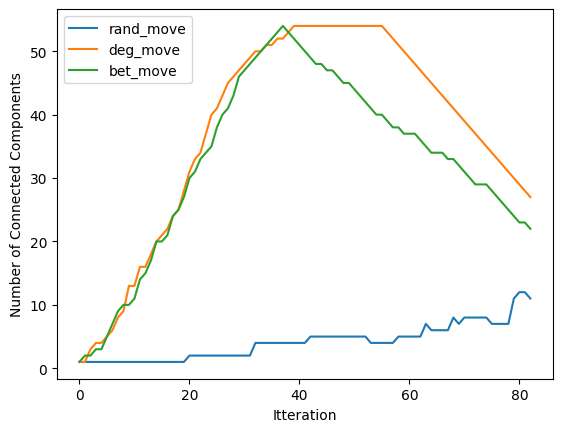

In [32]:
RANGE = round(len(G.nodes) * 0.75)
x = list(range(RANGE + 1))

# plot lines
plt.plot(x, rand_move, label="rand_move")
plt.plot(x, deg_move, label="deg_move")
plt.plot(x, bet_move, label="bet_move")

plt.xlabel("Itteration")
plt.ylabel("Number of Connected Components")

plt.legend()
plt.show()

Removing the node with the currently highest betweenness centrality made the number of connected components increase the fastest, while randomly removing nodes made the number of connected components increase the slowest. Removing the node with the current highest degree centrality had an intermediate effect on increasing the number of connected components. Because betweeness centrality rewards nodes that connect other nodes (i.e., are in the shortest path between two nodes), removing these nodes leads the network to fragment more quickly as these the path between nodes breaks apart. In comparison, when dropping nodes with the highest degree centrality, we are dropping nodes that have many connections in our network. However, just because a node has many connections it doesn't mean that it's removal will fragment the network as the nodes it points to could be holding the network together. Finaly randomly selecting nodes to drop you cannot be sure that a central and influential node will be removed, so it makes sense that it will take a longer time to fragment the network and increase the number of connected components. 